<a href="https://colab.research.google.com/github/jacekwachowiak/UCA-image-processing/blob/master/Advanced_K_Means_Clustering_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Clustering (student version)

Clustering algorithm is an important class of unsupervised machine learning models. It seeks to learn, from the properties of the data, an optimal division or discrete labeling of groups of points. Although many clustering algorithms are available in Scikit-Learn and elsewhere, implementing one from scratch is the best way for understanding. In this homework, we focus on the famous K-Means clustering method.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.datasets.samples_generator import make_blobs # for data generation
from sklearn.datasets.samples_generator import make_moons # for data generation

from sklearn import manifold, datasets

%matplotlib inline

## Overview

![Texte alternatif…](https://)The K-Means algorithm searches for a pre-determined number of clusters within an unlabeled multi-dimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster. 
* Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the K-Means model. We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the K-Means result.

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization.

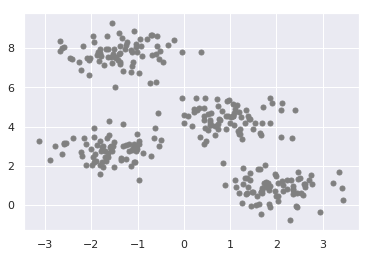

In [2]:
X, y_true = make_blobs(n_samples = 300, centers = 4,
                       cluster_std = 0.60, random_state = 0)
plt.scatter(X[:, 0], X[:, 1], s = 25, c = 'grey');

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [0]:
from sklearn.cluster import KMeans as SKMeans

kmeans = SKMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

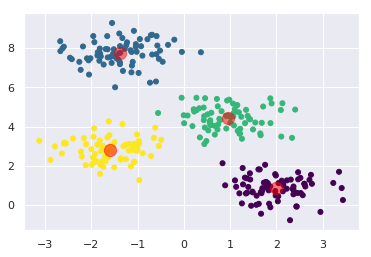

In [4]:
plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s = 25, cmap = 'viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 150, alpha = 0.5)

The good news is that the k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! Let's look through the pseudo-code of the K-Means clustering algorithm, given a point cloud $\mathcal{X} = \{x_1, \cdots, x_n\}$, the expected cluster number $K$:

1. Initialize $K$ cluster centers
2. Optimize the centers by Expectation-Maximization Algorithm
  - E-Step: assign all points in $\mathcal{X}$ to the nearest cluster center
  - M-Step: set each cluster center to the mean of its assigned points
  - Calculate the mean squared Euclidean distance from the points and its assigned centers.
3. Go back to step 2 unless one of the following condition is satisfied:
  - The maximum iteration number is attained
  - No point changes its assigned class (i.e. the algorithm is converged)
  
We will fill in the following class step by step:

In [0]:
class KMeans:
    
    def __init__(self, class_num, max_iter = 100, squared_dist = 0):
        self.class_num = class_num
        self.max_iter = max_iter
        self.squared_dist = squared_dist
        
    def fit(self, X):
        # initialize center
        # EM
        pass
        
    def predict(self, X):
        pass
    
    def center(self):
        pass

## Center Initialization

### Classical K-Means

The classical K-Means intializes the centers by random selection from the given point cloud.

In [0]:
def kmeans_init(X, class_num):
    
    assert(X.shape[0] > class_num), "The class number should be larger than the number of the points."
    
    idx = np.random.permutation(np.arange(X.shape[0]))[:class_num]
    
    return X[idx]

In [0]:
centers = kmeans_init(X, 4)

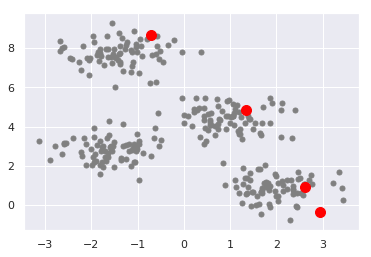

In [8]:
plt.scatter(X[:, 0], X[:, 1], s = 25, c = "grey", cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 100)

### K-Means++

Like the other EM algorithms, K-Means clustering is highly sensitive to the initial assignment of centers. K-Means++ attempts to make a good randomized choice of initial centers. This requires choosing a diverse set of centers, but not overpopulating the initial set of centers with outliers. K-Means++ has reasonable expected performance bounds in theory, and quite good performance in practice. It can be concluded as following:

1. Sample the first centroid $c_1$ randomly from $\mathcal{X}$.
2. For $k = 2$ to $K$, sample the next centroid $c_k = x$ with probability proportional to $D(x)^2$ where $D(x)$ is the minimum distance from a point $x$ to an existing centroid, i.e. $D(x) = \min_{k' < k} d(x,c_{k'})$

In [0]:
def kmeans_pp_init(X, class_num):
    
    assert(X.shape[0] > class_num), "The class number should be larger than the number of the points."
    
    # random choose the first center
    centers = X[np.random.randint(X.shape[0])].reshape((1, -1))
        
    # choose other centers one by one
    for i in range(1, class_num):
        dist = np.vstack([np.linalg.norm(X - centers, axis = 1) for centers in centers])
        dist = dist[np.argmin(dist, axis = 0), np.arange(X.shape[0])]
        dist_sum = dist.sum() * np.random.random()
            
        new_idx = np.argmax(np.cumsum(dist) - dist_sum > 0)
        centers = np.vstack((centers, X[new_idx].reshape((1, -1))))
        
    return centers

In [0]:
centers = kmeans_pp_init(X, 4)

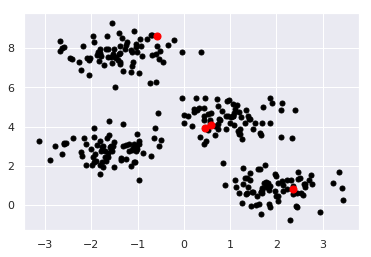

In [11]:
plt.scatter(X[:, 0], X[:, 1], s = 25, c = "black", cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'red', s = 50)

## Expectation-Maximization

In short, the expectation–maximization approach here consists of the two steps: E-step and M-step.

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

In [0]:
def EM_optimization(X, centers, max_iter):
    
    n, k = X.shape[0], centers.shape[0]
    iter_num = 0
    loss_hist = [1e10]
    
    while True:
        # E-step
        dist = np.vstack([np.linalg.norm(X - k_center, axis = 1) for k_center in centers])
        label = np.argmin(dist, axis = 0)
        loss = np.mean(np.power(dist[label, np.arange(n)], 2))
        iter_num += 1
        
        if iter_num < max_iter and loss < loss_hist[-1]:
            # M-step
            loss_hist.append(loss)
            centers = np.vstack([np.mean(X[label == i], axis = 0) for i in range(k)])
        else:
            break
            
    return centers, loss_hist[1:]

In [13]:
new_centers, loss_hist = EM_optimization(X, centers, 100)
print("Loss History: ")
for i in range(len(loss_hist)):
    print("- Iter %d: %f" % (i + 1, loss_hist[i]))

Loss History: 
- Iter 1: 2.489065
- Iter 2: 0.729295
- Iter 3: 0.706687


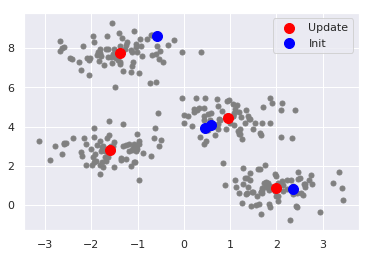

In [14]:
plt.scatter(X[:, 0], X[:, 1], c = 'grey', s = 25, cmap = 'viridis')
plt.scatter(new_centers[:, 0], new_centers[:, 1], c = 'red', s = 100, label = "Update")
plt.scatter(centers[:, 0], centers[:, 1], c = 'blue', s = 100, label = "Init")
plt.legend()

## Prediction

Given a new point cloud, we assign each point to its nearest center.

In [0]:
def predict(NX, centers):
    
    dist = np.vstack([np.linalg.norm(NX - k_center, axis = 1) for k_center in centers])
    label = np.argmin(dist, axis = 0)
    
    return label

In [0]:
NY = predict(X, new_centers)

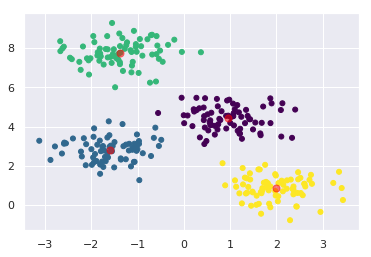

In [17]:
plt.scatter(X[:, 0], X[:, 1], c = NY, s = 25, cmap = 'viridis')
plt.scatter(new_centers[:, 0], new_centers[:, 1], c = 'red', s = 50, alpha = 0.5)

## Put It All Together

Although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the n_init parameter, which defaults to 10). Now let's put it all together.

In [0]:
class KMeans:
    
    def __init__(self, class_num, max_iter = 100, estim_num = 10):
        self.class_num = class_num
        self.max_iter = max_iter
        self.estim_num = estim_num
        self.m_centers = None
        
    # Kmeans++ if flag_pp is True, Kmeans otherwise.
    def fit(self, X, flag_pp = True):
        
        centers, loss_hist = None, [1e10]
        
        for i in range(self.estim_num):
            init_centers = self.kmeans_pp_init(X) if flag_pp else self.kmeans_init(X)
            curr_centers, curr_loss_hist = self.EM_optimization(X, init_centers)
            if curr_loss_hist[-1] < loss_hist[-1]:
                centers = curr_centers
                loss_hist = curr_loss_hist
        
        self.m_centers = centers
        self.loss_hist = loss_hist
        
    def predict(self, NX):
        dist = np.vstack([np.linalg.norm(NX - k_center, axis = 1) for k_center in self.m_centers])
        label = np.argmin(dist, axis = 0)
        return label
    
    def center(self):
        assert(type(self.m_centers) != type(None)), "Please run fit() before calling center()"
        return self.m_centers
    
    def loss(self):
        assert(type(self.m_centers) != type(None)), "Please run fit() before calling loss()"
        plt.plot(np.arange(len(self.loss_hist)), self.loss_hist)
        plt.title("Loss History - Min: %f" % self.loss_hist[-1])
        plt.show()
        
        return self.loss_hist
    
    def kmeans_init(self, X):
    
        assert(X.shape[0] > self.class_num), "The class number should be larger than the number of the points."
        idx = np.random.permutation(np.arange(X.shape[0]))[:self.class_num]
        return X[idx]

    def kmeans_pp_init(self, X):
    
        assert(X.shape[0] > self.class_num), "The class number should be larger than the number of the points."
        # random choose the first center
        centers = X[np.random.randint(X.shape[0])].reshape((1, -1))
        # choose other centers one by one
        for i in range(1, self.class_num):
            dist = np.vstack([np.linalg.norm(X - centers, axis = 1) for centers in centers])
            dist = dist[np.argmin(dist, axis = 0), np.arange(X.shape[0])]
            dist_sum = dist.sum() * np.random.random()
            # Update center
            new_idx = np.argmax(np.cumsum(dist) - dist_sum > 0)
            centers = np.vstack((centers, X[new_idx].reshape((1, -1))))
        return centers
    
    def EM_optimization(self, X, centers):
    
        n, k = X.shape[0], centers.shape[0]
        iter_num = 0
        loss_hist = [1e10]

        while True:
            # E-step
            dist = np.vstack([np.linalg.norm(X - k_center, axis = 1) for k_center in centers])
            label = np.argmin(dist, axis = 0)
            loss = np.mean(np.power(dist[label, np.arange(n)], 2))
            iter_num += 1
            if iter_num < self.max_iter and loss < loss_hist[-1]:
                # M-step
                loss_hist.append(loss)
                centers = np.vstack([np.mean(X[label == i], axis = 0) for i in range(k)])
            else:
                break

        return centers, loss_hist[1:]

### Example

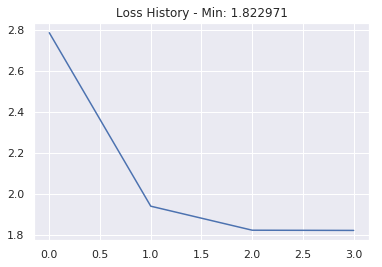

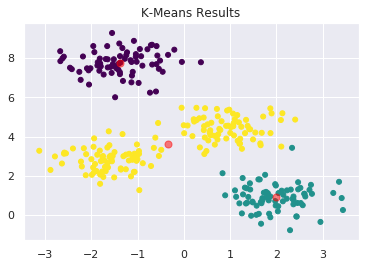

In [19]:
# Fit Dataset
clf = KMeans(3)
clf.fit(X, True)

# Get Result
new_centers = clf.center()
loss_hist = clf.loss()

# Plot Point Cloud
NY = clf.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = NY, s = 25, cmap = 'viridis')
plt.scatter(new_centers[:, 0], new_centers[:, 1], c = 'red', s = 50, alpha = 0.5)
plt.title("K-Means Results")
plt.show()

## TODO: Plot objective function against different random seeds

- For a given random point set with K clouds (K small such as 4), plot the final objective function after convergence (sum of squared distances from each point to its nearest cluster centroid) against different random initializations. 
- Compute the variance of such final functions.
- Compute in brute force the global minimum of the  objective function (for all possible constructions of K clusters). 


In [0]:
#insert your code here

## TODO: Over-relaxation
- Instead of relocating the current centroid, you can run "beyond the centroid using an over-relaxation parameter. study whether this improves convergence for cases where the initialization is bad,eg  with all generators in a corner of the domain.


In [0]:
#insert your code here

##TODO: Lloyd iteration on a Voronoi diagram
- Implement the Lloyd iteration algorithm using a Voronoi diagram https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/
careful: do not relocate the generators of infinite cells or use the halfspace-intersection paradigm to render each cell finite (or bounded).
- The centroid of a polygon is computed by triangulating the convex polygon and summing the  centroids (weighed by areas) and normalizing by the sum of areas.
- Experiment using different initializations and while densely sampling the boundary of a disk, and sampling sparsely its interior. Keep the boundary generators fixed.
- Experiment with over-relaxation, ie relocating beyond the center of mass.
- Experiment with momentum, ie a linear combination of the k previous locations. 

